# Use engineered features to train a model
This code will use the features created to train a Light Gradient Boost Model (lgbm).
The process is:
1. Run a lgbm model and compare it to a base model

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import re
import datetime as dt
from sklearn.metrics import roc_auc_score as auc_score
import matplotlib.pyplot as plt
from rf_modules import *
%matplotlib inline

In [2]:
#Import and combine prices files
path = r"C:\Users\Robert\Documents\python_scripts\stock_trading_ml_modelling\historical_prices"
df_ft = pd.read_hdf(path + r"\all_hist_prices_w_ft_eng2.h5")
print("SHAPE: {}".format(df_ft.shape))
print(df_ft.dtypes)
df_ft.head()

SHAPE: (258764, 106)
ticker                                       object
date                                 datetime64[ns]
open                                        float64
close                                       float64
high                                        float64
                                          ...      
long_prev_max_move_date_macd_line           float64
long_prev_min_move_date_macd_line           float64
long_max_grad_macd_line                     float64
long_min_grad_macd_line                     float64
signal                                       object
Length: 106, dtype: object


,ticker,date,open,close,high,low,volume,change_price,per_change_price,ema26,...,min_change_macd_line,prev_max_grad_macd_line,prev_min_grad_macd_line,max_move_cum_macd_line,min_move_cum_macd_line,long_prev_max_move_date_macd_line,long_prev_min_move_date_macd_line,long_max_grad_macd_line,long_min_grad_macd_line,signal
119903,III,2007-12-31,995.0,965.0,1023.0,964.0,4511565.0,-30.0,-0.031088,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,sell
119904,III,2008-01-07,967.5,924.0,989.0,917.5,16056554.0,-43.5,-0.047078,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,sell
119905,III,2008-01-14,917.0,901.0,936.0,881.0,21691287.0,-16.0,-0.017758,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,hold
119906,III,2008-01-21,891.0,917.5,965.0,847.0,17850580.0,26.5,0.028883,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,hold
119907,III,2008-01-28,911.0,961.0,971.0,903.0,12079245.0,50.0,0.052029,NaN,...,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,sell


In [3]:
df_ft.columns

Index(['ticker', 'date', 'open', 'close', 'high', 'low', 'volume',
       'change_price', 'per_change_price', 'ema26',
       ...
       'min_change_macd_line', 'prev_max_grad_macd_line',
       'prev_min_grad_macd_line', 'max_move_cum_macd_line',
       'min_move_cum_macd_line', 'long_prev_max_move_date_macd_line',
       'long_prev_min_move_date_macd_line', 'long_max_grad_macd_line',
       'long_min_grad_macd_line', 'signal'],
      dtype='object', length=106)

# Build the LGBM model
This model is designed to predict if a week should be buy, hold or sell.


In [4]:
#Import the feature cols
f = open(path + r'\feature_engineering_feature_list.txt','r')
feature_cols = f.read().split(',')
for col in ['signal','ticker']:
    try:
        feature_cols.remove(col)
    except:
        print('{} DOES NOT EXIST'.format(col))
print('feature_cols length -> {}'.format(len(feature_cols)))
feature_cols

feature_cols length -> 103


['open',
 'close',
 'high',
 'low',
 'volume',
 'change_price',
 'per_change_price',
 'ema26',
 'macd',
 'signal_line',
 'macd_line',
 'close_shift1',
 'change_close_shift1',
 'volume_shift1',
 'change_volume_shift1',
 'ema26_shift1',
 'change_ema26_shift1',
 'close_13_norm',
 'close_26_norm',
 'close_52_norm',
 'macd_line_13_norm',
 'macd_line_26_norm',
 'macd_line_52_norm',
 'close_max',
 'close_min',
 'prev_max_close',
 'prev_min_close',
 'prev_max_close_date_change',
 'prev_min_close_date_change',
 'max_change_close',
 'min_change_close',
 'prev_max_grad_close',
 'prev_min_grad_close',
 'max_move_cum_close',
 'min_move_cum_close',
 'long_prev_max_move_date_close',
 'long_prev_min_move_date_close',
 'long_max_grad_close',
 'long_min_grad_close',
 'macd_max',
 'macd_min',
 'prev_max_macd',
 'prev_min_macd',
 'prev_max_macd_date_change',
 'prev_min_macd_date_change',
 'max_change_macd',
 'min_change_macd',
 'prev_max_grad_macd',
 'prev_min_grad_macd',
 'max_move_cum_macd',
 'min_move_

In [5]:
target_cols = 'signal'
df_model = df_ft[feature_cols+[target_cols]+['date']].copy()
print("COLUMNS:",df_model.columns)
print("COLUMNS:",df_model.dtypes)
print("SHAPE:",df_model.shape)

COLUMNS: Index(['open', 'close', 'high', 'low', 'volume', 'change_price',
       'per_change_price', 'ema26', 'macd', 'signal_line',
       ...
       'prev_max_grad_macd_line', 'prev_min_grad_macd_line',
       'max_move_cum_macd_line', 'min_move_cum_macd_line',
       'long_prev_max_move_date_macd_line',
       'long_prev_min_move_date_macd_line', 'long_max_grad_macd_line',
       'long_min_grad_macd_line', 'signal', 'date'],
      dtype='object', length=105)
COLUMNS: open                                        float64
close                                       float64
high                                        float64
low                                         float64
volume                                      float64
                                          ...      
long_prev_min_move_date_macd_line           float64
long_max_grad_macd_line                     float64
long_min_grad_macd_line                     float64
signal                                       object
date 

In [6]:
#Remove rows with missing or infinate values
df_model.dropna(inplace=True)
df_model.reset_index(inplace=True)
print("COLUMNS:",df_model.columns)
print("SHAPE:",df_model.shape)

COLUMNS: Index(['index', 'open', 'close', 'high', 'low', 'volume', 'change_price',
       'per_change_price', 'ema26', 'macd',
       ...
       'prev_max_grad_macd_line', 'prev_min_grad_macd_line',
       'max_move_cum_macd_line', 'min_move_cum_macd_line',
       'long_prev_max_move_date_macd_line',
       'long_prev_min_move_date_macd_line', 'long_max_grad_macd_line',
       'long_min_grad_macd_line', 'signal', 'date'],
      dtype='object', length=106)
SHAPE: (228656, 106)


In [7]:
#Create the train and test dataset
#All prices pre-2014 are training, all post 2014 are testing
#This remove the posibility that we are learning from other shares at times what is good/bad
date_lim = dt.datetime(2014,1,1)

#Separate
df_train = df_model[df_model.date < date_lim]
df_valid = df_model[df_model.date >= date_lim]

#Reset the index and drop 'date' column
df_train = df_train.reset_index(drop=True).drop(columns=['date'])
df_valid = df_valid.reset_index(drop=True).drop(columns=['date'])

print("train rows: {:,}".format(df_train.shape[0]))
print("valid rows: {:,}".format(df_valid.shape[0]))

train rows: 146,747
valid rows: 81,909


In [8]:
#Shuffle the datasets
np.random.seed(0)
rand_index = np.random.permutation(df_train.index.values)
df_train = df_train.iloc[rand_index].reset_index(drop=True)
rand_index = np.random.permutation(df_valid.index.values)
df_valid = df_valid.iloc[rand_index].reset_index(drop=True)

In [9]:
#Function to calculate the True Positive Rate for each classifier
def calc_tpr(pred_signal_s,real_signal_s,features=[],unique_classes=['buy','sell','hold']):
    tpr_li = []
    for cl in unique_classes:
        true_pos = ((real_signal_s == cl) & (pred_signal_s == cl)).sum()
        false_pos = ((real_signal_s != cl) & (pred_signal_s == cl)).sum()
        true_neg = ((real_signal_s != cl) & (pred_signal_s != cl)).sum()
        false_neg = ((real_signal_s == cl) & (pred_signal_s != cl)).sum()
        #Calc tpr
        if sum([true_pos,false_neg]) != 0:
            tpr = true_pos / sum([true_pos,false_neg])
        else:
            tpr = 0
        #calc fpr
        if sum([true_pos,false_neg]) != 0:
            fpr = false_pos / sum([false_pos,true_neg])
        else:
            fpr = 0
        #calc accuracy
        if sum([true_pos,false_pos,true_neg,false_neg]) != 0:
            acc = sum([true_pos,true_neg])/sum([true_pos,false_pos,true_neg,false_neg])
        else:
            acc = 0
        if sum([true_pos,false_pos]) != 0:
            ppv = true_pos/sum([true_pos,false_pos])
        else:
            ppv = 0
        if sum([true_neg,false_neg]) != 0:
            npv = true_neg/sum([true_neg,false_neg])
        else:
            npv = 0
        #Calc the auc
        bool_pred_s = pred_signal_s == cl
        bool_real_s = real_signal_s == cl
        auc = auc_score(bool_real_s,bool_pred_s)
        tpr_li.append({
            "features":features.copy()
            ,"feature_count":len(features)
            ,"signal":cl
            ,"true_pos":true_pos
            ,"false_pos":false_pos
            ,"true_neg":true_neg
            ,"false_neg":false_neg
            ,"tpr":tpr
            ,"fpr":fpr
            ,"acc":acc
            ,"ppv":ppv
            ,"npv":npv
            ,"auc":auc
        })
        print('{} -> true_pos:{:.4f}, false_pos:{:.4f}, acc:{:.4f},ppv:{:.4f},npv:{:.4f},auc:{:.4f}'.format(cl,true_pos,false_pos,acc,ppv,npv,auc))
    tpr_df = pd.DataFrame(tpr_li,columns=["features","feature_count","signal","true_pos","false_pos","true_neg","false_neg","tpr","fpr","acc","ppv","npv","auc"])
    return tpr_df

# Separate into fetaures and targets 

In [10]:
#Train
X_train = df_train[feature_cols]
y_train = df_train[target_cols]
print('X_train.shape -> {}'.format(X_train.shape))
#Validation
X_valid = df_valid[feature_cols]
y_valid = df_valid[target_cols]
print('X_valid.shape -> {}'.format(X_valid.shape))

X_train.shape -> (146747, 103)
X_valid.shape -> (81909, 103)


# Create a base level model
For "buy", "sell" and "hold" test what the accuracy is if all signals are positive.

In [11]:
#Buy model
unique_classes = y_valid.unique()
calc_tpr(np.full((1,y_valid.shape[0]),"buy")[0],y_valid,["ALL BUY"],unique_classes)

hold -> true_pos:0.0000, false_pos:0.0000, acc:0.4374,ppv:0.0000,npv:0.4374,auc:0.5000
sell -> true_pos:0.0000, false_pos:0.0000, acc:0.7406,ppv:0.0000,npv:0.7406,auc:0.5000
buy -> true_pos:14587.0000, false_pos:67322.0000, acc:0.1781,ppv:0.1781,npv:0.0000,auc:0.5000


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[ALL BUY],1,hold,0,0,35831,46078,0.0,0.0,0.437449,0.000000,0.437449,0.5
1,[ALL BUY],1,sell,0,0,60665,21244,0.0,0.0,0.740639,0.000000,0.740639,0.5
2,[ALL BUY],1,buy,14587,67322,0,0,1.0,1.0,0.178088,0.178088,0.000000,0.5


In [12]:
#Sell model
calc_tpr(np.full((1,y_valid.shape[0]),"sell")[0],y_valid,["ALL SELL"],unique_classes)

hold -> true_pos:0.0000, false_pos:0.0000, acc:0.4374,ppv:0.0000,npv:0.4374,auc:0.5000
sell -> true_pos:21244.0000, false_pos:60665.0000, acc:0.2594,ppv:0.2594,npv:0.0000,auc:0.5000
buy -> true_pos:0.0000, false_pos:0.0000, acc:0.8219,ppv:0.0000,npv:0.8219,auc:0.5000


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[ALL SELL],1,hold,0,0,35831,46078,0.0,0.0,0.437449,0.000000,0.437449,0.5
1,[ALL SELL],1,sell,21244,60665,0,0,1.0,1.0,0.259361,0.259361,0.000000,0.5
2,[ALL SELL],1,buy,0,0,67322,14587,0.0,0.0,0.821912,0.000000,0.821912,0.5


In [13]:
#Buy model
calc_tpr(np.full((1,y_valid.shape[0]),"hold")[0],y_valid,["ALL HOLD"],unique_classes)

hold -> true_pos:46078.0000, false_pos:35831.0000, acc:0.5626,ppv:0.5626,npv:0.0000,auc:0.5000
sell -> true_pos:0.0000, false_pos:0.0000, acc:0.7406,ppv:0.0000,npv:0.7406,auc:0.5000
buy -> true_pos:0.0000, false_pos:0.0000, acc:0.8219,ppv:0.0000,npv:0.8219,auc:0.5000


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[ALL HOLD],1,hold,46078,35831,0,0,1.0,1.0,0.562551,0.562551,0.000000,0.5
1,[ALL HOLD],1,sell,0,0,60665,21244,0.0,0.0,0.740639,0.000000,0.740639,0.5
2,[ALL HOLD],1,buy,0,0,67322,14587,0.0,0.0,0.821912,0.000000,0.821912,0.5


# Creating a multi-classification model - LGBM
The model will take a one-vs-all approach (IE 1 if it is this value, 0 if it is anything else) using the variables of "buy", "hold", and "sell" individually and building a model to find the error rate on each one.

Error rate is determined by the four classifications:
- True positive - correct - model is 1, actual is 1
- True negative - correct - model is 0, actual is 0
- False positive - error - model is 1, actual is 0
- False negative - error - model is 0, actual is 1

In [14]:
#Import the modules
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [15]:
#Build a custom loss function
def lgbm_custom_loss(_y_act,_y_pred):
    print('_y_act.shape -> {}'.format(_y_act.shape))
    print('_y_act -> {}'.format(_y_act))
    print('_y_pred.shape -> {}'.format(_y_pred.shape))
    print('_y_pred -> {}'.format(_y_pred))
    #Binary classify _y_pred
    _y_pred[_y_pred < 0.5] = 0
    _y_pred[_y_pred >= 0.5] = 1
    _ppv = measure_acc(_y_pred,_y_act)['ppv']
    return 'lgbm_custom_loss',_ppv,True

In [16]:
#Create parameters grid
#Create fixed parameters
mod_fixed_params = {
    'boosting_type':'gbdt'
    ,'random_state':0
    ,'silent':False
    ,'objective':'multiclass'
    ,'num_class':y_train.unique().shape[0]
}
print('mod_fixed_params -> {}'.format(mod_fixed_params))
search_params = {
    'fixed':{
        'cv':3
        ,'n_iter':80
        ,'verbose':True
    }
    ,'variable':{
        'learning_rate':[0.1,0.01,0.005]
        ,'num_leaves':np.linspace(10,1010,100,dtype=int)
        ,'max_depth':np.linspace(2,22,10,dtype=int)
    }
}
print('search_params -> {}'.format(search_params))
fit_params = {
    'verbose':True
#     ,'eval_set':[(X_valid,y_valid)]
#     ,'eval_metric':lgbm_custom_loss
}
print('fit_params -> {}'.format(fit_params))

mod_fixed_params -> {'boosting_type': 'gbdt', 'random_state': 0, 'silent': False, 'objective': 'multiclass', 'num_class': 3}
search_params -> {'fixed': {'cv': 3, 'n_iter': 80, 'verbose': True}, 'variable': {'learning_rate': [0.1, 0.01, 0.005], 'num_leaves': array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  111,
        121,  131,  141,  151,  161,  171,  181,  191,  201,  212,  222,
        232,  242,  252,  262,  272,  282,  292,  302,  313,  323,  333,
        343,  353,  363,  373,  383,  393,  403,  414,  424,  434,  444,
        454,  464,  474,  484,  494,  504,  515,  525,  535,  545,  555,
        565,  575,  585,  595,  605,  616,  626,  636,  646,  656,  666,
        676,  686,  696,  706,  717,  727,  737,  747,  757,  767,  777,
        787,  797,  807,  818,  828,  838,  848,  858,  868,  878,  888,
        898,  908,  919,  929,  939,  949,  959,  969,  979,  989,  999,
       1010]), 'max_depth': array([ 2,  4,  6,  8, 10, 13, 15, 17, 19, 22])}}
fit_par

In [17]:
run_time = process_time()
#Setup the model
lgb_mod = lgb.LGBMClassifier(**mod_fixed_params)
#Add the search grid
gbm = RandomizedSearchCV(lgb_mod,search_params['variable'],**search_params['fixed'])
#Fitthe model
gbm.fit(X_train,y_train,**fit_params)
print('Best parameters found by grid search are: {}'.format(gbm.best_params_))
run_time.end()

Fitting 3 folds for each of 80 candidates, totalling 240 fits


C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 267.6min finished


Best parameters found by grid search are: {'num_leaves': 515, 'max_depth': 22, 'learning_rate': 0.1}
TOTAL ELAPSED TIME -> 4:29:29


# Train the final model

In [18]:
final_models = lgb.LGBMClassifier(**gbm.best_params_)
final_models.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=22,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=515, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [19]:
print('classes_ -> {}'.format(final_models.classes_))

classes_ -> ['buy' 'hold' 'sell']


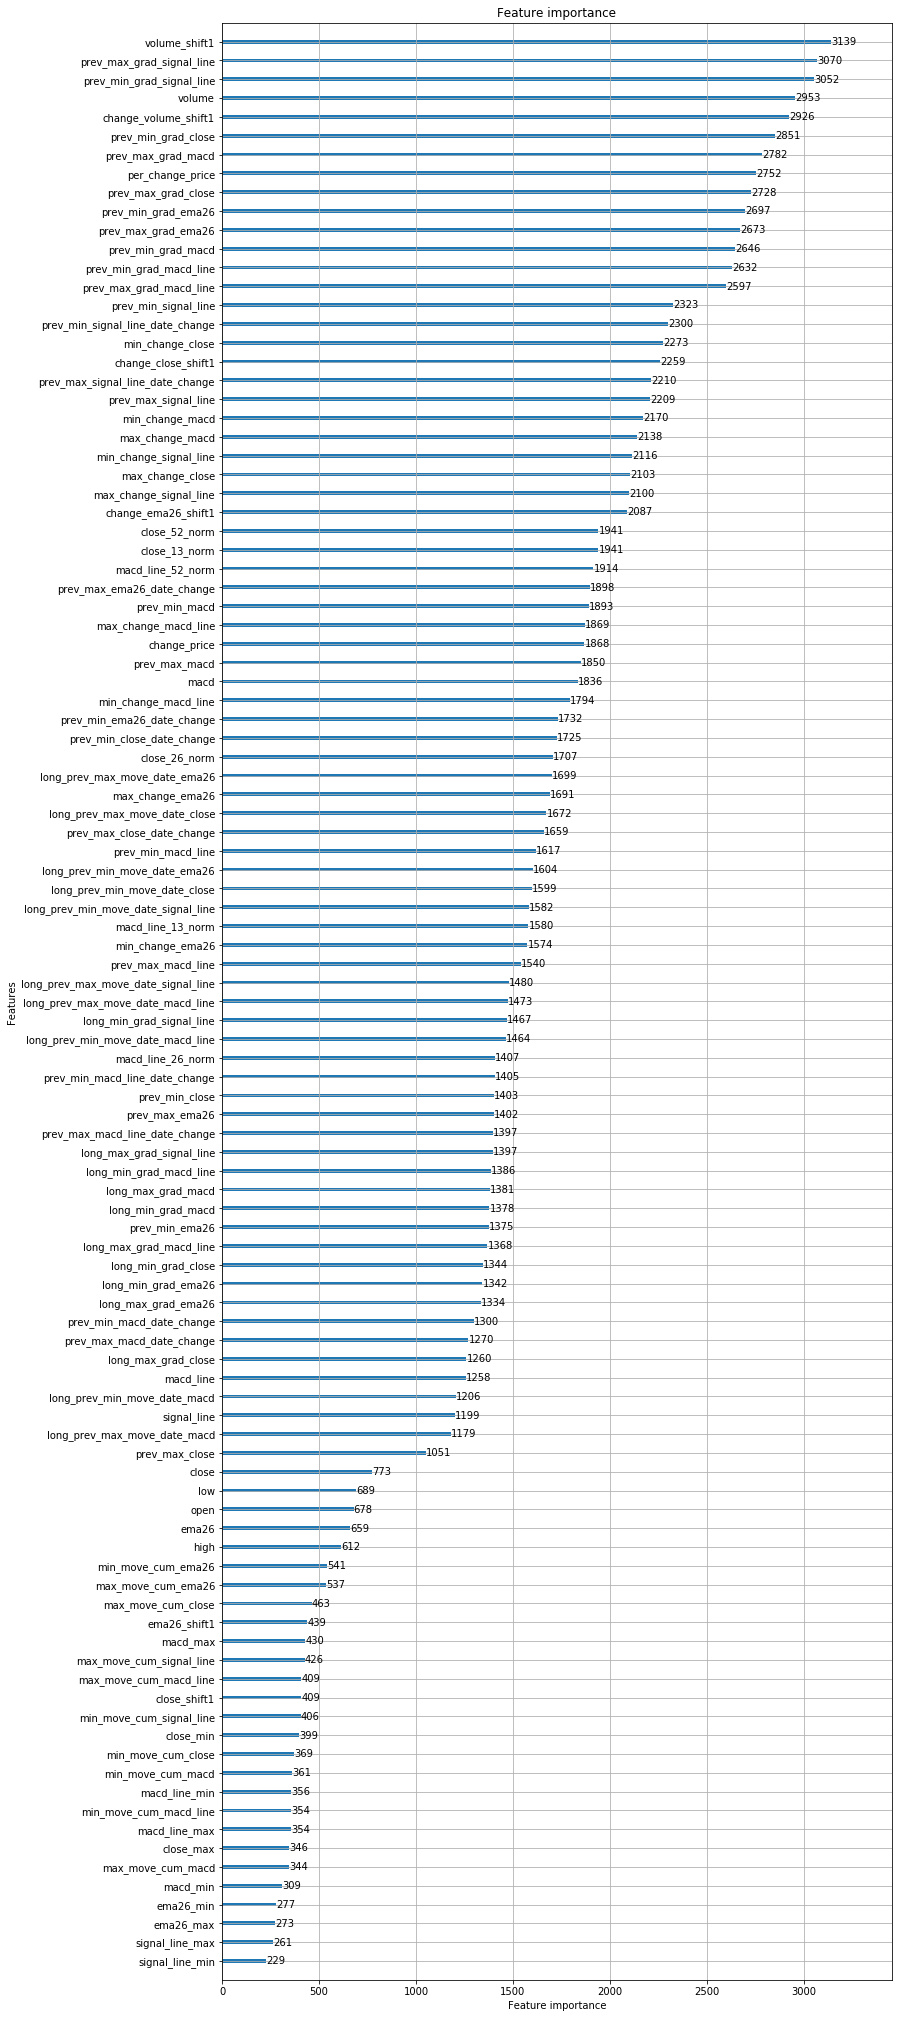

In [20]:
lgb.plot_importance(final_models,figsize=(12,36))

In [25]:
y_pred = final_models.predict(X_valid)
calc_tpr(y_pred,y_valid,['FINAL RF MODEL - VALIDATION SET'],y_valid.unique())    

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


hold -> true_pos:36158.0000, false_pos:20639.0000, acc:0.6269,ppv:0.6366,npv:0.6050,auc:0.6044
sell -> true_pos:10209.0000, false_pos:5251.0000, acc:0.8012,ppv:0.6603,npv:0.8339,auc:0.6970
buy -> true_pos:4820.0000, false_pos:4832.0000, acc:0.8218,ppv:0.4994,npv:0.8648,auc:0.6293


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[FINAL RF MODEL - VALIDATION SET],1,hold,36158,20639,15192,9920,0.784713,0.576010,0.626915,0.636618,0.604970,0.604352
1,[FINAL RF MODEL - VALIDATION SET],1,sell,10209,5251,55414,11035,0.480559,0.086557,0.801170,0.660349,0.833933,0.697001
2,[FINAL RF MODEL - VALIDATION SET],1,buy,4820,4832,62490,9767,0.330431,0.071774,0.821766,0.499378,0.864830,0.629328


In [26]:
y_pred = final_models.predict(X_train)
calc_tpr(y_pred,y_train,['FINAL RF MODEL - TRAINING SET'],y_train.unique())    

C:\Users\Robert\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


buy -> true_pos:30313.0000, false_pos:690.0000, acc:0.9675,ppv:0.9777,npv:0.9648,auc:0.9377
hold -> true_pos:74037.0000, false_pos:7891.0000, acc:0.9337,ppv:0.9037,npv:0.9716,auc:0.9322
sell -> true_pos:32622.0000, false_pos:1194.0000, acc:0.9656,ppv:0.9647,npv:0.9658,auc:0.9417


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[FINAL RF MODEL - TRAINING SET],1,buy,30313,690,111667,4077,0.881448,0.006141,0.967516,0.977744,0.964776,0.937653
1,[FINAL RF MODEL - TRAINING SET],1,hold,74037,7891,62978,1841,0.975737,0.111346,0.933682,0.903684,0.971598,0.932196
2,[FINAL RF MODEL - TRAINING SET],1,sell,32622,1194,109074,3857,0.894268,0.010828,0.965580,0.964691,0.965846,0.941720


# Exporting the model

In [22]:
#Import the modules
from sklearn.externals import joblib as jl

In [23]:
#Export the model
jl.dump(final_models,path+r'\lgb_model.joblib')

['C:\\Users\\Robert\\Documents\\python_scripts\\stock_trading_ml_modelling\\historical_prices\\lgb_model.joblib']

In [24]:
#Export a list of the features for this model
file_object = open(path+r'\lgb_model_feature_list.txt','w')
feature_str = ''
for i in feature_cols:
    feature_str += '{},'.format(i)
feature_str = feature_str[:-1]
file_object.write(feature_str)
file_object.close()
feature_str

'open,close,high,low,volume,change_price,per_change_price,ema26,macd,signal_line,macd_line,close_shift1,change_close_shift1,volume_shift1,change_volume_shift1,ema26_shift1,change_ema26_shift1,close_13_norm,close_26_norm,close_52_norm,macd_line_13_norm,macd_line_26_norm,macd_line_52_norm,close_max,close_min,prev_max_close,prev_min_close,prev_max_close_date_change,prev_min_close_date_change,max_change_close,min_change_close,prev_max_grad_close,prev_min_grad_close,max_move_cum_close,min_move_cum_close,long_prev_max_move_date_close,long_prev_min_move_date_close,long_max_grad_close,long_min_grad_close,macd_max,macd_min,prev_max_macd,prev_min_macd,prev_max_macd_date_change,prev_min_macd_date_change,max_change_macd,min_change_macd,prev_max_grad_macd,prev_min_grad_macd,max_move_cum_macd,min_move_cum_macd,long_prev_max_move_date_macd,long_prev_min_move_date_macd,long_max_grad_macd,long_min_grad_macd,ema26_max,ema26_min,prev_max_ema26,prev_min_ema26,prev_max_ema26_date_change,prev_min_ema26_date